# **Installation and Imports**

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import math

# Model Related
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix, log_loss
from lightgbm import LGBMRegressor, early_stopping, log_evaluation, LGBMClassifier
from xgboost import XGBRegressor

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# **Load Processed DataFrames**

In [ ]:
load_path = "/content/drive/MyDrive/DS_LAB/Processed/pkl/"

filtered_user1 = pd.read_pickle(load_path + "filtered_user1.pkl")
filtered_user2 = pd.read_pickle(load_path + "filtered_user2.pkl")
combined_df   = pd.read_pickle(load_path + "combined_df.pkl")

print("DataFrames loaded")
print(f"User1 shape: {filtered_user1.shape}")
print(f"User2 shape: {filtered_user2.shape}")
print(f"Combined shape: {combined_df.shape}")

DataFrames loaded
User1 shape: (645, 15)
User2 shape: (645, 15)
Combined shape: (1290, 15)


# **Classification Approach - Logistic Regression**

In [ ]:
def ensure_sorted(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['datetime'].dtype, np.datetime64):
        df['datetime'] = pd.to_datetime(df['datetime'])
    return df.sort_values('datetime').reset_index(drop=True)

sorted_user1 = ensure_sorted(filtered_user1)
print("Data sorted chronologically.")

def engineer_classification_features(df: pd.DataFrame):
    df = df.copy()
    df['y_next'] = df['wpm'].shift(-1)
    df['wpm_delta'] = df['y_next'] - df['wpm']

    bin_width = 3.0
    def classify_performance(delta):
        if delta > bin_width:
            return 'Increase'
        elif delta < -bin_width:
            return 'Decrease'
        else:
            return 'Stable'
    df['y_class'] = df['wpm_delta'].apply(classify_performance)

    df['wpm_lag1'] = df['wpm'].shift(1)
    df['wpm_ewm3'] = df['wpm'].ewm(span=3, min_periods=1, adjust=False).mean()
    df['wpm_roll3_mean'] = df['wpm'].rolling(3, min_periods=1).mean()
    df['wpm_cummean'] = df['wpm'].expanding(min_periods=1).mean()

    return df

featured_df = engineer_classification_features(sorted_user1)
print("Features and classification target created.")

Data sorted chronologically.
Features and classification target created.


In [ ]:
focused_feature_cols = [
    'wpm',
    'wpm_ewm3',
    'consistency',
    'wpm_roll3_mean',
    'acc',
    'wpm_cummean'
]

final_df = featured_df.dropna(subset=['y_class', 'wpm_lag1']).copy()
X = final_df[focused_feature_cols].astype(float)
y = final_df['y_class']
print(f"Using {len(focused_feature_cols)} features: {focused_feature_cols}")

Using 6 features: ['wpm', 'wpm_ewm3', 'consistency', 'wpm_roll3_mean', 'acc', 'wpm_cummean']


In [ ]:
def time_split_single(X, y, train=0.9, test=0.1):
    n = len(X)
    i1 = int(n * train)
    X_tr, X_te = X.iloc[:i1], X.iloc[i1:]
    y_tr, y_te = y.iloc[:i1], y.iloc[i1:]
    return X_tr, X_te, y_tr, y_te

X_tr, X_te, y_tr, y_te = time_split_single(X, y)
print(f"Training set size: {len(X_tr)}, Test set size: {len(X_te)}")

Training set size: 579, Test set size: 65


In [ ]:
pipe_logreg = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

param_grid_logreg = {
    'model__C': [0.01, 0.1, 1, 10]
}

tscv = TimeSeriesSplit(n_splits=3)

grid_search_logreg = GridSearchCV(
    estimator=pipe_logreg,
    param_grid=param_grid_logreg,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV for Logistic Regression + Polynomial Features")
grid_search_logreg.fit(X_tr, y_tr)

Running GridSearchCV for Logistic Regression + Polynomial Features...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1, param_grid={'model__C': [0.01, 0.1, 1, 10]}, verbose=1)

In [ ]:
print("\n--- Polynomial Logistic Regression Grid Search Complete ---")
print(f"Best parameters found: {grid_search_logreg.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_logreg.best_score_:.2%}")

best_poly_model = grid_search_logreg.best_estimator_
y_pred_poly = best_poly_model.predict(X_te)
y_pred_proba_poly = best_poly_model.predict_proba(X_te)

print("\n--- Final Model Performance on Test Set ---")
accuracy_poly = accuracy_score(y_te, y_pred_poly)
loss_poly = log_loss(y_te, y_pred_proba_poly)

print(f"Final Classification Accuracy: {accuracy_poly:.2%}")
print(f"Final Log-Loss: {loss_poly:.4f}\n")

print("Classification Report:")
print(classification_report(y_te, y_pred_poly, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_te, y_pred_poly, labels=['Decrease', 'Stable', 'Increase']))


--- Polynomial Logistic Regression Grid Search Complete ---
Best parameters found: {'model__C': 10}
Best cross-validation accuracy: 50.23%

--- Final Model Performance on Test Set ---
Final Classification Accuracy: 60.00%
Final Log-Loss: 0.8892

Classification Report:
              precision    recall  f1-score   support

    Decrease       0.70      0.74      0.72        19
    Increase       0.67      0.56      0.61        25
      Stable       0.46      0.52      0.49        21

    accuracy                           0.60        65
   macro avg       0.61      0.61      0.61        65
weighted avg       0.61      0.60      0.60        65


Confusion Matrix:
[[14  5  0]
 [ 3 11  7]
 [ 3  8 14]]


# **Classification Approach - SVC**

In [ ]:
def ensure_sorted(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['datetime'].dtype, np.datetime64):
        df['datetime'] = pd.to_datetime(df['datetime'])
    return df.sort_values('datetime').reset_index(drop=True)

sorted_user1 = ensure_sorted(filtered_user1)
print("Data sorted chronologically.")

def engineer_classification_features(df: pd.DataFrame):
    df = df.copy()
    df['y_next'] = df['wpm'].shift(-1)
    df['wpm_delta'] = df['y_next'] - df['wpm']

    bin_width = 3.0
    def classify_performance(delta):
        if delta > bin_width:
            return 'Increase'
        elif delta < -bin_width:
            return 'Decrease'
        else:
            return 'Stable'
    df['y_class'] = df['wpm_delta'].apply(classify_performance)

    df['wpm_lag1'] = df['wpm'].shift(1)
    df['wpm_ewm3'] = df['wpm'].ewm(span=3, min_periods=1, adjust=False).mean()
    df['wpm_roll3_mean'] = df['wpm'].rolling(3, min_periods=1).mean()
    df['wpm_roll20_mean'] = df['wpm'].rolling(20, min_periods=1).mean()
    df['wpm_ewm5'] = df['wpm'].ewm(span=5, min_periods=1, adjust=False).mean()
    df['wpm_minus_roll3'] = df['wpm'] - df['wpm_roll3_mean']
    df['wpm_cummean'] = df['wpm'].expanding(min_periods=1).mean()
    time_map = {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}
    df['tod_numeric'] = df['time_of_day'].map(time_map)
    df['tod_sin'] = np.sin(2 * np.pi * df['tod_numeric'] / 4)
    df['tod_cos'] = np.cos(2 * np.pi * df['tod_numeric'] / 4)

    return df

Data sorted chronologically.


In [ ]:
featured_df = engineer_classification_features(sorted_user1)
print("Features and classification target created.")

final_feature_cols = [
    'wpm', 'acc', 'consistency',
    'wpm_lag1',
    'wpm_roll3_mean',
    'wpm_ewm3', 'wpm_ewm5',
    'wpm_minus_roll3',
    'wpm_cummean',
    'wpm_roll20_mean',
    'tod_sin', 'tod_cos'
]

focused_feature_cols = [
    'wpm',
    'wpm_ewm3',
    'consistency',
    'wpm_roll3_mean',
    'acc',
    'wpm_cummean'
]

final_df = featured_df.dropna(subset=['y_class', 'wpm_lag1']).copy()
X = final_df[focused_feature_cols].astype(float)
y = final_df['y_class']

print(f"Using {len(focused_feature_cols)} features: {focused_feature_cols}")

Features and classification target created.
Using 6 features: ['wpm', 'wpm_ewm3', 'consistency', 'wpm_roll3_mean', 'acc', 'wpm_cummean']


In [ ]:
def time_split_single(X, y, train=0.9, test=0.1):
    n = len(X)
    i1 = int(n * train)
    X_tr, X_te = X.iloc[:i1], X.iloc[i1:]
    y_tr, y_te = y.iloc[:i1], y.iloc[i1:]
    return X_tr, X_te, y_tr, y_te

X_tr, X_te, y_tr, y_te = time_split_single(X, y)
print(f"Training set size: {len(X_tr)}, Test set size: {len(X_te)}")

Training set size: 579, Test set size: 65


In [ ]:
scaler_svc = StandardScaler()
X_tr_scaled = scaler_svc.fit_transform(X_tr)
X_te_scaled = scaler_svc.transform(X_te)
print("Features scaled for SVC.")

param_grid_svc = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'linear']
}

tscv = TimeSeriesSplit(n_splits=3)

grid_search_svc = GridSearchCV(
    estimator=SVC(class_weight='balanced', random_state=42, probability=True),
    param_grid=param_grid_svc,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

Features scaled for SVC.


In [ ]:
print("Running GridSearchCV for SVC")
grid_search_svc.fit(X_tr_scaled, y_tr)

print("\n--- SVC Grid Search Complete ---")
print(f"Best parameters found: {grid_search_svc.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_svc.best_score_:.2%}")

best_svc_model = grid_search_svc.best_estimator_

Running GridSearchCV for SVC
Fitting 3 folds for each of 32 candidates, totalling 96 fits

--- SVC Grid Search Complete ---
Best parameters found: {'C': 50, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 48.84%


In [ ]:
y_pred_svc = best_svc_model.predict(X_te_scaled)
y_pred_proba_svc = best_svc_model.predict_proba(X_te_scaled)

print("\n--- Final SVC Model Performance on Test Set ---")
accuracy_svc = accuracy_score(y_te, y_pred_svc)
loss_svc = log_loss(y_te, y_pred_proba_svc)

print(f"Final Classification Accuracy: {accuracy_svc:.2%}")
print(f"Final Log-Loss: {loss_svc:.4f}\n")

print("Classification Report:")
print(classification_report(y_te, y_pred_svc, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_te, y_pred_svc, labels=['Decrease', 'Stable', 'Increase']))


--- Final SVC Model Performance on Test Set ---
Final Classification Accuracy: 55.38%
Final Log-Loss: 0.8853

Classification Report:
              precision    recall  f1-score   support

    Decrease       0.70      0.74      0.72        19
    Increase       0.61      0.44      0.51        25
      Stable       0.41      0.52      0.46        21

    accuracy                           0.55        65
   macro avg       0.57      0.57      0.56        65
weighted avg       0.57      0.55      0.55        65


Confusion Matrix:
[[14  5  0]
 [ 3 11  7]
 [ 3 11 11]]


# **Classification Approach - LightGBM**

In [ ]:
def ensure_sorted(df: pd.DataFrame, user_col: str | None = None) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['datetime'].dtype, np.datetime64):
        df['datetime'] = pd.to_datetime(df['datetime'])
    if user_col and user_col in df.columns:
        return df.sort_values([user_col, 'datetime']).reset_index(drop=True)
    return df.sort_values('datetime').reset_index(drop=True)

sorted_user1 = ensure_sorted(filtered_user1, user_col=None)
print("Data sorted chronologically.")
sorted_user1.head(3)

Data sorted chronologically.


,user_id,datetime,time_of_day,wpm,rawWpm,acc,consistency,restartCount,testDuration,afkDuration,incompleteTestSeconds,correct_characters,incorrect_characters,extra_characters,missed_characters
0,1,2024-11-10 08:36:37,morning,69.56,71.56,95.68,73.83,0,30.02,0,0.0,174,1,0,0
1,1,2024-11-10 08:37:10,morning,56.80,58.80,95.42,63.73,0,30.00,0,0.0,142,1,0,0
2,1,2024-11-10 08:37:48,morning,62.80,70.80,91.06,76.91,0,30.00,0,0.0,157,10,0,3


In [ ]:
def engineer_classification_features(df: pd.DataFrame):
    df = df.copy()

    df['y_next'] = df['wpm'].shift(-1)
    df['wpm_delta'] = df['y_next'] - df['wpm']

    bin_width = 3.0
    def classify_performance(delta):
        if delta > bin_width:
            return 'Increase'
        elif delta < -bin_width:
            return 'Decrease'
        else:
            return 'Stable'

    df['y_class'] = df['wpm_delta'].apply(classify_performance)
    df['wpm_lag1'] = df['wpm'].shift(1)
    df['wpm_roll3_mean'] = df['wpm'].rolling(3, min_periods=1).mean()
    df['wpm_roll20_mean'] = df['wpm'].rolling(20, min_periods=1).mean()
    df['wpm_ewm3'] = df['wpm'].ewm(span=3, min_periods=1, adjust=False).mean()
    df['wpm_ewm5'] = df['wpm'].ewm(span=5, min_periods=1, adjust=False).mean()
    df['wpm_minus_roll3'] = df['wpm'] - df['wpm_roll3_mean']
    df['wpm_cummean'] = df['wpm'].expanding(min_periods=1).mean()

    # df['time_since_last'] = (df['datetime'] - df['datetime'].shift(1)).dt.total_seconds() / 3600.0

    time_map = {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}
    df['tod_numeric'] = df['time_of_day'].map(time_map)
    df['tod_sin'] = np.sin(2 * np.pi * df['tod_numeric'] / 4)
    df['tod_cos'] = np.cos(2 * np.pi * df['tod_numeric'] / 4)

    return df

featured_df = engineer_classification_features(sorted_user1)
print("Features and classification target created.")
print("Class Distribution:\n", featured_df['y_class'].value_counts())

Features and classification target created.
Class Distribution:
 y_class
Increase    229
Decrease    216
Stable      200
Name: count, dtype: int64


In [ ]:
final_feature_cols = [
    'wpm',
    'wpm_ewm3',
    'consistency',
    'wpm_roll3_mean',
    'acc',
    'wpm_cummean'
    # 'time_since_last'
]

final_df = featured_df.dropna(subset=['y_class', 'wpm_lag1']).copy()
X = final_df[final_feature_cols].astype(float)
y = final_df['y_class']

print("Final X and y shapes:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Final X and y shapes:
X shape: (644, 6)
y shape: (644,)


In [ ]:
def time_split_single(X, y, meta=None, train=0.9, val=0.0, test=0.1):
    n = len(X)
    i1 = int(n * train)
    i2 = int(n * (train + val))

    X_tr, y_tr = X.iloc[:i1], y.iloc[:i1]
    X_va, y_va = X.iloc[i1:i2], y.iloc[i1:i2]
    X_te, y_te = X.iloc[i2:],  y.iloc[i2:]

    if meta is not None:
        meta_tr, meta_va, meta_te = meta.iloc[:i1], meta.iloc[i1:i2], meta.iloc[i2:]
        return X_tr, y_tr, X_va, y_va, X_te, y_te, meta_tr, meta_va, meta_te

    return X_tr, y_tr, X_va, y_va, X_te, y_te

X_tr, y_tr, _, _, X_te, y_te = time_split_single(X, y, train=0.9, val=0.0, test=0.1)
print("Train size:", X_tr.shape, y_tr.shape)
print("Test size:", X_te.shape, y_te.shape)

Train size: (579, 6) (579,)
Test size: (65, 6) (65,)


In [ ]:
print("\n--- Class Distribution Check ---")
print("Training Set (y_tr) Class Counts:")
print(y_tr.value_counts())
print("\nTest Set (y_te) Class Counts:")
print(y_te.value_counts())
print("---------------------------------")


--- Class Distribution Check ---
Training Set (y_tr) Class Counts:
y_class
Increase    204
Decrease    196
Stable      179
Name: count, dtype: int64

Test Set (y_te) Class Counts:
y_class
Increase    25
Stable      21
Decrease    19
Name: count, dtype: int64
---------------------------------


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1101
[LightGBM] [Info] Number of data points in the train set: 579, number of used features: 6
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

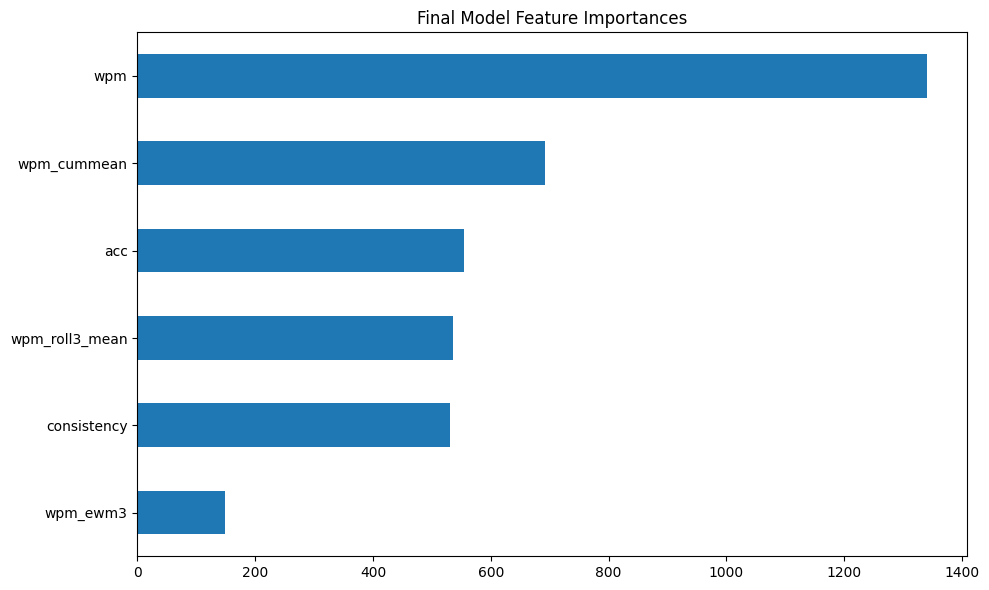

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [8, 12, 16],
    'max_depth': [3, 4, 5]
}

lgbm_clf = LGBMClassifier(class_weight='balanced', random_state=42)
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1)
grid_search.fit(X_tr, y_tr)

print("\n--- Grid Search Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2%}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_te)


print("\n--- Final Model Performance on Test Set ---")
accuracy = accuracy_score(y_te, y_pred_best)
print(f"Final Classification Accuracy: {accuracy:.2%}\n")
print("Classification Report:")
print(classification_report(y_te, y_pred_best, zero_division=0))
print("\nConfusion Matrix:")
print(confusion_matrix(y_te, y_pred_best, labels=['Decrease', 'Stable', 'Increase']))
print()

plt.figure(figsize=(10, 6))
pd.Series(best_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('Final Model Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
lgbm_clf = LGBMClassifier(
    class_weight='balanced',
    max_depth=4,
    n_estimators=200,
    random_state=42,
    num_leaves = 8,
    learning_rate = 0.01
)

lgbm_clf.fit(X_tr, y_tr)
print("Model training complete.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1101
[LightGBM] [Info] Number of data points in the train set: 579, number of used features: 6
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

Classification Accuracy: 69.23%

Classification Report:
              precision    recall  f1-score   support

    Decrease       0.74      0.89      0.81        19
    Increase       0.68      0.60      0.64        25
      Stable       0.65      0.62      0.63        21

    accuracy                           0.69        65
   macro avg       0.69      0.70      0.69        65
weighted avg       0.69      0.69      0.69        65


Confusion Matrix:
[[17  1  1]
 [ 2 13  6]
 [ 4  6 15]]



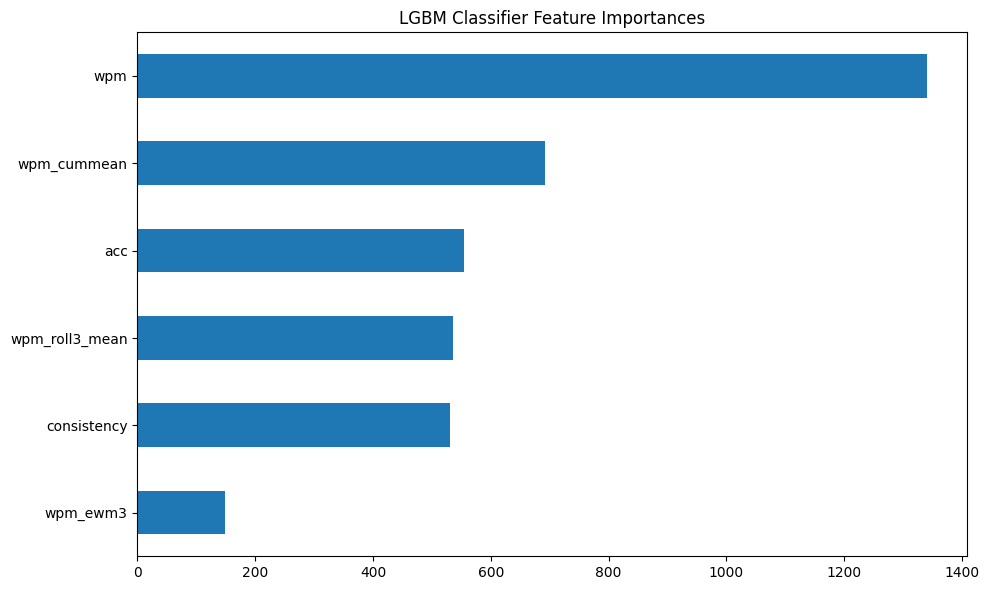

In [ ]:
y_pred = lgbm_clf.predict(X_te)
accuracy = accuracy_score(y_te, y_pred)
print(f"Classification Accuracy: {accuracy:.2%}\n")
print("Classification Report:")
print(classification_report(y_te, y_pred, zero_division=0))
print("\nConfusion Matrix:")
print(confusion_matrix(y_te, y_pred, labels=['Decrease', 'Stable', 'Increase']))
print()
plt.figure(figsize=(10, 6))
pd.Series(lgbm_clf.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('LGBM Classifier Feature Importances')
plt.tight_layout()
plt.show()

# **Feature Engineering**

In [ ]:
def ensure_sorted(df: pd.DataFrame, user_col: str | None = None) -> pd.DataFrame:
    df = df.copy()
    if not np.issubdtype(df['datetime'].dtype, np.datetime64):
        df['datetime'] = pd.to_datetime(df['datetime'])
    if user_col and user_col in df.columns:
        return df.sort_values([user_col, 'datetime']).reset_index(drop=True)
    return df.sort_values('datetime').reset_index(drop=True)

filtered_user1 = ensure_sorted(filtered_user1, user_col=None)
filtered_user1.head(3)

,user_id,datetime,time_of_day,wpm,rawWpm,acc,consistency,restartCount,testDuration,afkDuration,incompleteTestSeconds,correct_characters,incorrect_characters,extra_characters,missed_characters
0,1,2024-11-10 08:36:37,morning,69.56,71.56,95.68,73.83,0,30.02,0,0.0,174,1,0,0
1,1,2024-11-10 08:37:10,morning,56.80,58.80,95.42,63.73,0,30.00,0,0.0,142,1,0,0
2,1,2024-11-10 08:37:48,morning,62.80,70.80,91.06,76.91,0,30.00,0,0.0,157,10,0,3


In [ ]:
def engineer_final_features(
    df: pd.DataFrame,
    *,
    target_col: str = "wpm"):

    df = df.copy()
    df["y_next"] = df[target_col].shift(-1)

    cur_feats = ["wpm", "acc", "consistency"]
    lag_steps = (1, 2)
    roll_windows = (3, 5)

    for k in lag_steps:
        df[f"wpm_lag{k}"] = df["wpm"].shift(k)
        df[f"acc_lag{k}"] = df["acc"].shift(k)
        df[f"consistency_lag{k}"] = df["consistency"].shift(k)

    for w in roll_windows:
        df[f"wpm_roll{w}_mean"] = df["wpm"].rolling(w, min_periods=1).mean()
        df[f"wpm_roll{w}_std"]  = df["wpm"].rolling(w, min_periods=2).std()
        df[f"acc_roll{w}_mean"] = df["acc"].rolling(w, min_periods=1).mean()
        df[f"acc_roll{w}_std"]  = df["acc"].rolling(w, min_periods=2).std()

    for span in (3, 5, 10):
        df[f"wpm_ewm{span}"] = df["wpm"].ewm(span=span, min_periods=1, adjust=False).mean()
        df[f"acc_ewm{span}"] = df["acc"].ewm(span=span, min_periods=1, adjust=False).mean()

    df["wpm_cummean"] = df["wpm"].expanding(min_periods=1).mean()
    df["wpm_diff1"] = df["wpm"] - df["wpm"].shift(1)

    for w in roll_windows:
        mean_col = f"wpm_roll{w}_mean"
        dev_col  = f"wpm_minus_roll{w}"
        df[dev_col] = df["wpm"] - df[mean_col]

    time_map = {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}
    df['tod_numeric'] = df['time_of_day'].map(time_map)
    df['tod_sin'] = np.sin(2 * np.pi * df['tod_numeric'] / 4)
    df['tod_cos'] = np.cos(2 * np.pi * df['tod_numeric'] / 4)
    df['wpm_roll20_mean'] = df["wpm"].rolling(20, min_periods=1).mean()

    final_feature_cols = [
        'wpm', 'acc', 'consistency',
        'wpm_lag1',
        'wpm_roll3_mean',
        'wpm_ewm3', 'wpm_ewm5',
        'wpm_minus_roll3',
        'wpm_cummean',
        'wpm_roll20_mean',
        'tod_sin', 'tod_cos'
    ]

    std_cols = [c for c in df.columns if c.endswith("_std")]
    for c in std_cols:
        df[c].fillna(0, inplace=True)

    required = ["y_next", "wpm_lag1"]
    sup = df.dropna(subset=required).copy()
    X = sup[final_feature_cols].astype(float)
    X = X.fillna(X.median()).fillna(0)
    y = sup["y_next"].astype(float)
    meta = sup[["datetime"]].copy()

    return sup, X, y, final_feature_cols, meta

supervised_u1, X_u1, y_u1, feat_cols_u1, meta_u1 = engineer_final_features(filtered_user1)
print("X shape:", X_u1.shape)
print("Y shape:", y_u1.shape)
print("Any NaNs in X?", X_u1.isna().any().any())
print("NaN counts (by column) in X (if any):")
print(X_u1.isna().sum()[X_u1.isna().sum() > 0])
print("Feature sample:", feat_cols_u1[:20])
print()
X_u1.head(3)

X shape: (643, 12)
Y shape: (643,)
Any NaNs in X? False
NaN counts (by column) in X (if any):
Series([], dtype: int64)
Feature sample: ['wpm', 'acc', 'consistency', 'wpm_lag1', 'wpm_roll3_mean', 'wpm_ewm3', 'wpm_ewm5', 'wpm_minus_roll3', 'wpm_cummean', 'wpm_roll20_mean', 'tod_sin', 'tod_cos']



/tmp/ipython-input-2224793745.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(0, inplace=True)


,wpm,acc,consistency,wpm_lag1,wpm_roll3_mean,wpm_ewm3,wpm_ewm5,wpm_minus_roll3,wpm_cummean,wpm_roll20_mean,tod_sin,tod_cos
1,56.80,95.42,63.73,69.56,63.180000,63.18,65.306667,-6.380000,63.180000,63.180000,0.0,1.0
2,62.80,91.06,76.91,56.80,63.053333,62.99,64.471111,-0.253333,63.053333,63.053333,0.0,1.0
3,66.79,94.05,74.85,62.80,62.130000,64.89,65.244074,4.660000,63.987500,63.987500,0.0,1.0


In [ ]:
# Leakage Audit
audit_cols = ["datetime","wpm","y_next","wpm_lag1","wpm_lag2","wpm_roll3_mean"]
print(supervised_u1[audit_cols].head(12))

              datetime    wpm  y_next  wpm_lag1  wpm_lag2  wpm_roll3_mean
1  2024-11-10 08:37:10  56.80   62.80     69.56       NaN       63.180000
2  2024-11-10 08:37:48  62.80   66.79     56.80     69.56       63.053333
3  2024-11-10 08:38:22  66.79   75.16     62.80     56.80       62.130000
4  2024-11-11 09:00:17  75.16   65.99     66.79     62.80       68.250000
5  2024-11-11 11:44:06  65.99   73.19     75.16     66.79       69.313333
6  2024-11-11 11:44:39  73.19   73.20     65.99     75.16       71.446667
7  2024-11-11 11:46:20  73.20   65.97     73.19     65.99       70.793333
8  2024-11-11 11:46:54  65.97   71.18     73.20     73.19       70.786667
9  2024-11-11 11:47:27  71.18   67.99     65.97     73.20       70.116667
10 2024-11-11 11:48:02  67.99   64.40     71.18     65.97       68.380000
11 2024-11-11 11:48:39  64.40   64.39     67.99     71.18       67.856667
12 2024-11-11 11:49:13  64.39   62.40     64.40     67.99       65.593333


In [ ]:
def time_split_single(X, y, meta, train=0.7, val=0.15, test=0.15):
    n = len(meta)
    i1 = int(n * train)
    i2 = int(n * (train + val))

    X_tr, y_tr = X.iloc[:i1], y.iloc[:i1]
    X_va, y_va = X.iloc[i1:i2], y.iloc[i1:i2]
    X_te, y_te = X.iloc[i2:],  y.iloc[i2:]

    return X_tr, y_tr, X_va, y_va, X_te, y_te

X_tr, y_tr, _, _, X_te, y_te = time_split_single(X_u1, y_u1, meta_u1, train=0.9, val=0.0, test=0.1)

print("Train size:", X_tr.shape, y_tr.shape)
print("Test size:", X_te.shape, y_te.shape)

Train size: (578, 12) (578,)
Test size: (65, 12) (65,)


In [ ]:
def eval_regression(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> MAE: {mae:.3f} | RMSE: {rmse:.3f}")

baseline_last = X_te["wpm"]
baseline_roll3 = X_te["wpm_roll3_mean"].fillna(baseline_last)

eval_regression("Baseline (next = current WPM)", y_te, baseline_last)
eval_regression("Baseline (next = rolling-3 WPM)", y_te, baseline_roll3)

Baseline (next = current WPM) -> MAE: 6.730 | RMSE: 8.905
Baseline (next = rolling-3 WPM) -> MAE: 5.534 | RMSE: 7.167


# **Supervised Learning - RFR**

In [ ]:
def eval_regression_with_acc(name, y_true, y_pred, tol=3.0):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    accuracy = np.mean(np.abs(y_true - y_pred) <= tol) * 100
    print(f"{name} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | Accuracy (±{tol} WPM): {accuracy:.2f}%")

In [ ]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=7,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr, np.log1p(y_tr))

log_preds_rf = rf.predict(X_te)
y_te_pred_rf = np.expm1(log_preds_rf)
y_te_actual_wpm = y_te

print("Random Forest (next-WPM)")
eval_regression_with_acc("Test", y_te_actual_wpm, y_te_pred_rf, tol=3.0)

Random Forest (next-WPM)
Test -> MAE: 5.210 | RMSE: 6.840 | Accuracy (±3.0 WPM): 41.54%


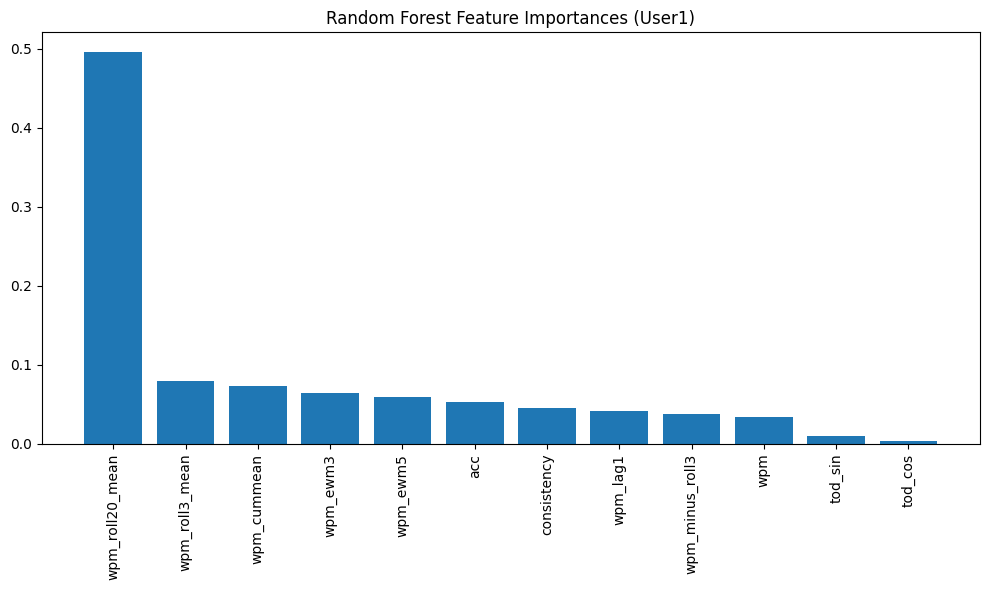

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feat_cols_u1[i] for i in indices], rotation=90)
plt.title("Random Forest Feature Importances (User1)")
plt.tight_layout()
plt.show()


Plotting results


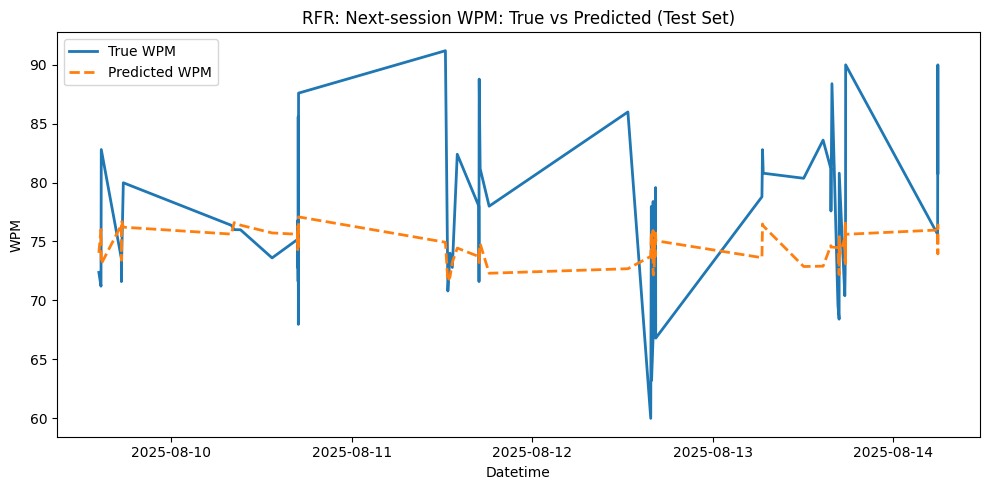

In [ ]:
print("\nPlotting results")
plt.figure(figsize=(10,5))
plt.plot(meta_u1.iloc[len(X_tr):]['datetime'], y_te_actual_wpm.values, label="True WPM", linewidth=2)
plt.plot(meta_u1.iloc[len(X_tr):]['datetime'], y_te_pred_rf, label="Predicted WPM", linewidth=2, linestyle="--")
plt.xlabel("Datetime")
plt.ylabel("WPM")
plt.title("RFR: Next-session WPM: True vs Predicted (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

# **Supervised Learning - LightGBM**

In [ ]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_tr, np.log1p(y_tr))
log_preds_ridge = ridge_model.predict(X_te)
y_te_pred_ridge = log_preds_ridge

print("\n--- Diagnostic Model: Ridge Regression ---")
baseline_pred = X_te['wpm']
print("Baseline (next = current WPM)")
eval_regression_with_acc("Test", y_te, baseline_pred, tol=3.0)

print("\nRidge Regression Results")
eval_regression_with_acc("Test", y_te, y_te_pred_ridge, tol=3.0)


--- Diagnostic Model: Ridge Regression ---
Baseline (next = current WPM)
Test -> MAE: 6.730 | RMSE: 8.905 | Accuracy (±3.0 WPM): 32.31%

Ridge Regression Results
Test -> MAE: 72.224 | RMSE: 72.519 | Accuracy (±3.0 WPM): 0.00%


In [ ]:
lgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.1,
    "num_leaves": 8,
    "max_depth": 3,
    "min_child_samples": 20,
    "reg_lambda": 0.5,
    "random_state": 42,
    "n_jobs": -1,
}

model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(
    X_tr, np.log1p(y_tr),
    eval_set=[(X_te, np.log1p(y_te))],
    eval_metric="l1",
    callbacks=[early_stopping(50), log_evaluation(100)]
)

log_predictions = model_lgb.predict(X_te, num_iteration=model_lgb.best_iteration_)
y_te_pred_lgbm = np.expm1(log_predictions)
y_te_actual_wpm = y_te

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1807
[LightGBM] [Info] Number of data points in the train set: 578, number of used features: 12
[LightGBM] [Info] Start training from score 4.253210
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [ ]:
def eval_regression_with_acc(name, y_true, y_pred, tol=3.0):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    accuracy = np.mean(np.abs(y_true - y_pred) <= tol) * 100
    print(f"{name} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | Accuracy (±{tol} WPM): {accuracy:.2f}%")

print("LightGBM (next-WPM)")
eval_regression_with_acc("Test", y_te_actual_wpm, y_te_pred_lgbm, tol=3.0)

LightGBM (next-WPM)
Test -> MAE: 5.053 | RMSE: 6.681 | Accuracy (±3.0 WPM): 46.15%


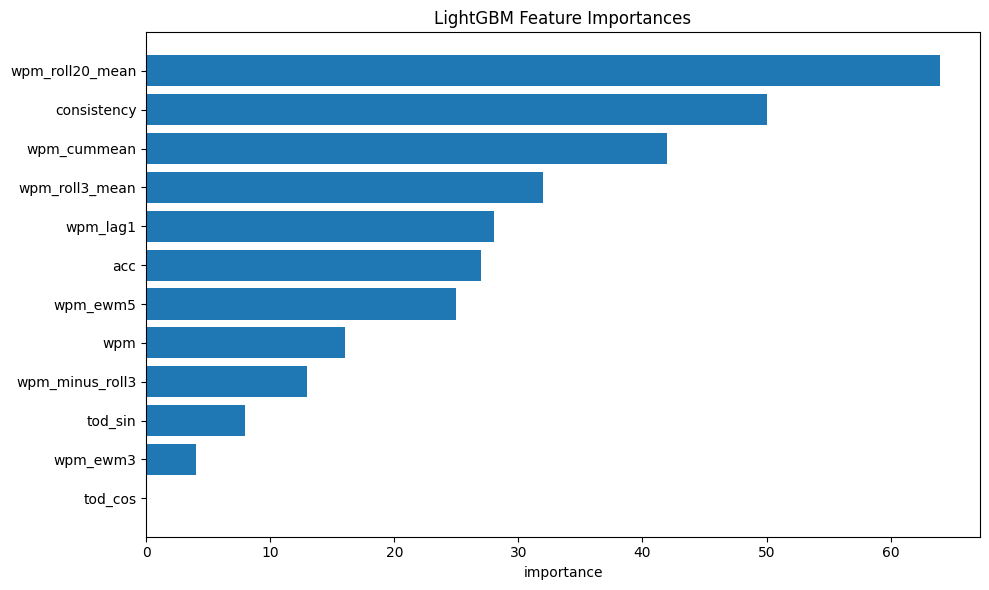

In [ ]:
importances = model_lgb.feature_importances_
feat_names = X_tr.columns.to_list()
imp_df = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False))

plt.figure(figsize=(10,6))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.title("LightGBM Feature Importances")
plt.xlabel("importance")
plt.tight_layout()
plt.show()


Plotting results


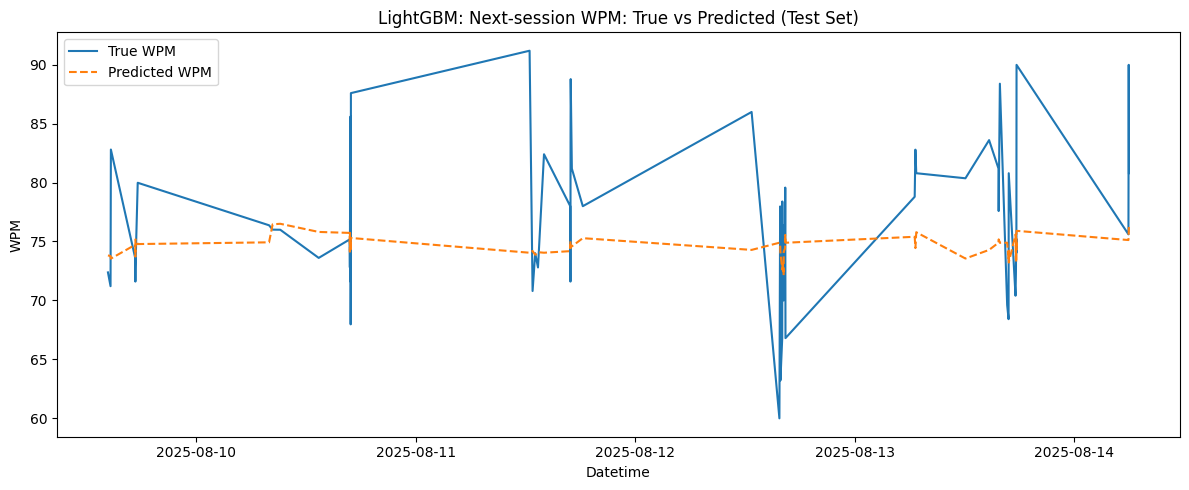

In [ ]:
print("\nPlotting results")
meta_te = meta_u1.iloc[len(X_tr):].reset_index(drop=True)
y_te_reset = y_te_actual_wpm.reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(meta_te["datetime"], y_te_reset, label="True WPM")
plt.plot(meta_te["datetime"], pd.Series(y_te_pred_lgbm), "--", label="Predicted WPM")
plt.title("LightGBM: Next-session WPM: True vs Predicted (Test Set)")
plt.xlabel("Datetime")
plt.ylabel("WPM")
plt.legend()
plt.tight_layout()
plt.show()

# **Supervised Learning - XGBoost**

In [ ]:
xgb_params = {
    "n_estimators": 800,
    "learning_rate": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0.5,
    "min_child_weight": 10,
    "reg_alpha": 0.1,
    "random_state": 42,
    "n_jobs": -1,
}

model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(X_tr, np.log1p(y_tr))
log_preds_xgb = model_xgb.predict(X_te)
y_te_pred_xgb = np.expm1(log_preds_xgb)
y_te_actual_wpm = y_te

print("XGBoost (next-WPM)")
eval_regression("Test", y_te, y_te_pred_xgb)

XGBoost (next-WPM)
Test -> MAE: 5.649 | RMSE: 7.431


In [ ]:
def eval_regression_with_acc(name, y_true, y_pred, tol=3.0):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    accuracy = np.mean(np.abs(y_true - y_pred) <= tol) * 100
    print(f"{name} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | Accuracy (±{tol} WPM): {accuracy:.2f}%")

print("XGBoost (next-WPM)")
eval_regression_with_acc("Test", y_te_actual_wpm, y_te_pred_xgb, tol=3.0)

XGBoost (next-WPM)
Test -> MAE: 5.649 | RMSE: 7.431 | Accuracy (±3.0 WPM): 43.08%


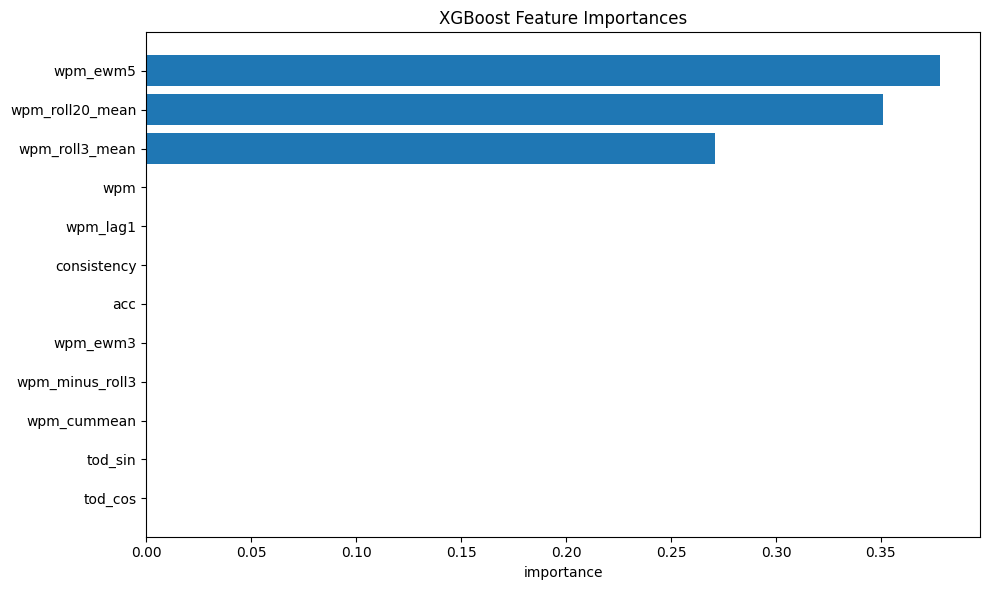

In [ ]:
imp_vals = model_xgb.feature_importances_
feat_names = X_tr.columns.to_list()
imp_df = pd.DataFrame({"feature": feat_names, "importance": imp_vals}).sort_values("importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.title("XGBoost Feature Importances")
plt.xlabel("importance")
plt.tight_layout()
plt.show()


Plotting results


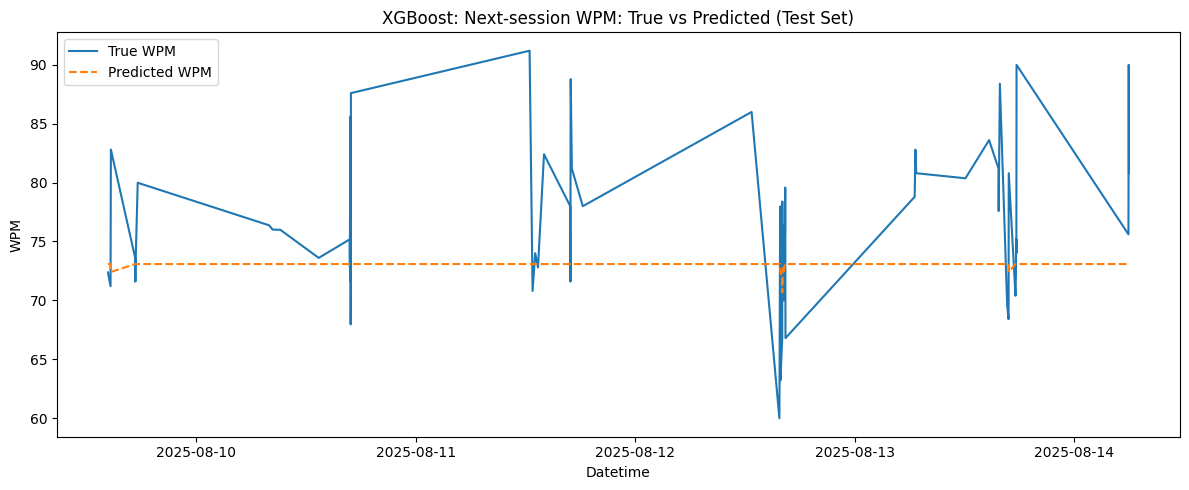

In [ ]:
print("\nPlotting results")
meta_te = meta_u1.iloc[len(X_tr):].reset_index(drop=True)
y_te_reset = y_te_actual_wpm.reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(meta_te["datetime"], y_te_reset, label="True WPM")
plt.plot(meta_te["datetime"], pd.Series(y_te_pred_xgb), "--", label="Predicted WPM")
plt.title("XGBoost: Next-session WPM: True vs Predicted (Test Set)")
plt.xlabel("Datetime")
plt.ylabel("WPM")
plt.legend()
plt.tight_layout()
plt.show()

# **Linear Regression**

In [ ]:
def ensure_sorted(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df.sort_values('datetime').reset_index(drop=True)

sorted_user1 = ensure_sorted(filtered_user1)
print("Data sorted chronologically.")

Data sorted chronologically.


In [ ]:
def engineer_features_for_wpm(df: pd.DataFrame):
    df = df.copy()
    df['y_next'] = df['wpm'].shift(-1)
    df['wpm_ewm3'] = df['wpm'].ewm(span=3, min_periods=1, adjust=False).mean()
    df['wpm_roll3_mean'] = df['wpm'].rolling(3, min_periods=1).mean()
    df['wpm_cummean'] = df['wpm'].expanding(min_periods=1).mean()

    return df

featured_df = engineer_features_for_wpm(sorted_user1)
print("Features and regression target (y_next) created.")

Features and regression target (y_next) created.


In [ ]:
final_feature_cols = [
    'wpm',
    'wpm_ewm3',
    'consistency',
    'wpm_roll3_mean',
    'acc',
    'wpm_cummean'
]

final_df = featured_df.dropna(subset=['y_next']).copy()
X = final_df[final_feature_cols]
y = np.log1p(final_df['y_next'])

In [ ]:
def time_split_single(X, y, train=0.9, test=0.1):
    n = len(X)
    i1 = int(n * train)

    X_tr, X_te = X.iloc[:i1], X.iloc[i1:]
    y_tr, y_te = y.iloc[:i1], y.iloc[i1:]

    return X_tr, X_te, y_tr, y_te

X_tr, X_te, y_tr, y_te = time_split_single(X, y)
print(f"\nTraining set size: {len(X_tr)}")
print(f"Test set size: {len(X_te)}")


Training set size: 579
Test set size: 65


In [ ]:
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_te_scaled = scaler.transform(X_te)
print("\nFeatures scaled.")


Features scaled.


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_tr_scaled, y_tr)
print("Linear Regression model trained.")

Linear Regression model trained.


In [ ]:
log_preds = lin_reg.predict(X_te_scaled)
y_pred_wpm = np.expm1(log_preds)
y_te_wpm = np.expm1(y_te)

def eval_regression_with_acc(name, y_true, y_pred, tol=3.0):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    accuracy = np.mean(np.abs(y_true - y_pred) <= tol) * 100
    print(f"{name} -> MAE: {mae:.3f} | RMSE (Loss): {rmse:.3f} | Accuracy (±{tol} WPM): {accuracy:.2f}%")

print("\n--- Model Evaluation ---")
baseline_pred = X_te['wpm']
eval_regression_with_acc("Baseline (next = current WPM)", y_te_wpm, baseline_pred)
eval_regression_with_acc("Linear Regression (Predicted Log WPM)", y_te_wpm, y_pred_wpm)


--- Model Evaluation ---
Baseline (next = current WPM) -> MAE: 6.730 | RMSE (Loss): 8.905 | Accuracy (±3.0 WPM): 32.31%
Linear Regression (Predicted Log WPM) -> MAE: 5.078 | RMSE (Loss): 6.655 | Accuracy (±3.0 WPM): 43.08%
